In [64]:
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, Dataset
import numpy as np

class ContrastiveLearningViewGenerator:
    def __init__(self, num_patch=4, scale_min=0.25, scale_max=0.25, ratio_min=1, ratio_max=1):
        self.num_patch = num_patch
        self.scale_min = scale_min
        self.scale_max = scale_max
        self.ratio_min = ratio_min
        self.ratio_max = ratio_max

    def __call__(self, x):
        # Augmentation transforms
        aug_transform = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(self.scale_min, self.scale_max), ratio=(self.ratio_min, self.ratio_max)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.2)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor()
        ])

        # Apply the augmentation transforms to the input PIL image multiple times
        augmented_x = [aug_transform(x) for _ in range(self.num_patch)]
        return augmented_x

class CustomCIFAR20Dataset(Dataset):
    def __init__(self, root, superclasses, transform=None, target_transform=None):
        self.superclasses = superclasses
        self.data = []
        self.targets = []
        self.fine_targets = []
        self.transform = transform
        self.target_transform = target_transform

        # Load the CIFAR-100 dataset and filter it based on superclasses
        cifar100 = CIFAR100(root=root, train=True, download=True)

        # Create a mapping from CIFAR-100 classes to the 20 superclasses
        class_to_superclass = {}
        for i, (superclass, classes) in enumerate(superclasses):
            for class_name in classes:
                class_idx = cifar100.class_to_idx[class_name]
                class_to_superclass[class_idx] = i

        for i in range(len(cifar100)):
            img, target = cifar100[i]

            superclass_idx = class_to_superclass[target]
            self.data.append(np.array(img))
            self.targets.append(superclass_idx)
            self.fine_targets.append(target)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target, fine_target = self.data[idx], self.targets[idx], self.fine_targets[idx]
        if self.transform is not None:
            img = self.transform(img)  # Apply the custom transformation
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, fine_target

def load_cifar20_coarse(train=True, num_patch=3, path="./data/"):
    # Define the list of 20 superclasses and their corresponding classes
    superclasses = [
        ['aquatic mammals', ['beaver', 'dolphin', 'otter', 'seal', 'whale']],
        ['fish', ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout']],
        ['flowers', ['orchid', 'poppy', 'rose', 'sunflower', 'tulip']],
        ['food containers', ['bottle', 'bowl', 'can', 'cup', 'plate']],
        ['fruit and vegetables', ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper']],
        ['household electrical devices', ['clock', 'keyboard', 'lamp', 'telephone', 'television']],
        ['household furniture', ['bed', 'chair', 'couch', 'table', 'wardrobe']],
        ['insects', ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach']],
        ['large carnivores', ['bear', 'leopard', 'lion', 'tiger', 'wolf']],
        ['large man-made outdoor things', ['bridge', 'castle', 'house', 'road', 'skyscraper']],
        ['large natural outdoor scenes', ['cloud', 'forest', 'mountain', 'plain', 'sea']],
        ['large omnivores and herbivores', ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo']],
        ['medium-sized mammals', ['fox', 'porcupine', 'possum', 'raccoon', 'skunk']],
        ['non-insect invertebrates', ['crab', 'lobster', 'snail', 'spider', 'worm']],
        ['people', ['baby', 'boy', 'girl', 'man', 'woman']],
        ['reptiles', ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle']],
        ['small mammals', ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']],
        ['trees', ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree']],
        ['vehicles 1', ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train']],
        ['vehicles 2', ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']],
    ]


    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert NumPy array to PIL image
        ContrastiveLearningViewGenerator(num_patch=num_patch),

    ])

    # Initialize the dataset for train or test data
    dataset = CustomCIFAR20Dataset(root='./data', superclasses=superclasses, transform=transform)

    return dataset

In [87]:
def load_cifar100_class_names():
    # Define the CIFAR-100 class names based on the CIFAR-100 dataset documentation
    class_names_cifar100 = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
        'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
        'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
        'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
        'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
        'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
        'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar',
        'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
        'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
    ]

    return class_names_cifar100

In [88]:
def show_images(images, labels, fine_labels):
    class_names = [
        'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
        'household electrical devices', 'household furniture', 'insects', 'large carnivores',
        'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
        'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
        'trees', 'vehicles 1', 'vehicles 2'
    ]

    num_patches = len(images)


    for i in range(BS):
      for j in range(num_patches):
        image = images[j][i]
        label = labels[i]
        plt.figure()
        plt.imshow(image.permute(1, 2, 0))
        print('Coarse label = ' ,class_names[label])
        fine_class_names = load_cifar100_class_names()
        fine_label = fine_labels[i]
        class_name_fine = fine_class_names[fine_label]
        print('Fine_label = ', class_name_fine)

Files already downloaded and verified
Coarse label =  large natural outdoor scenes
Fine_label =  cloud
Coarse label =  large natural outdoor scenes
Fine_label =  cloud
Coarse label =  large omnivores and herbivores
Fine_label =  camel
Coarse label =  large omnivores and herbivores
Fine_label =  camel


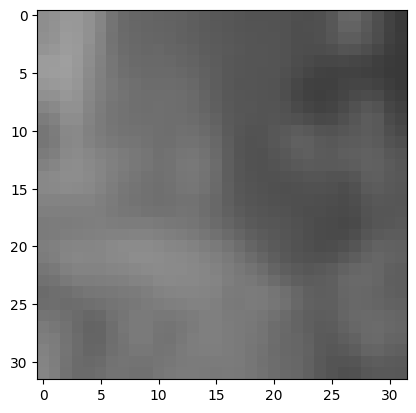

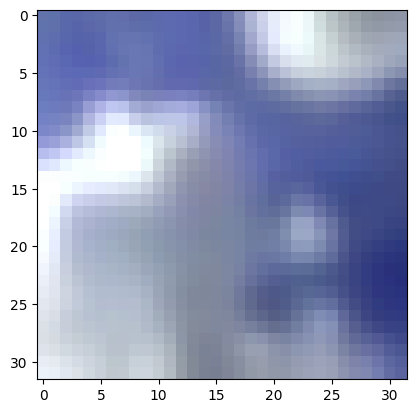

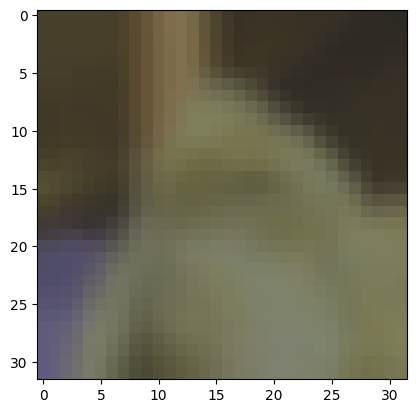

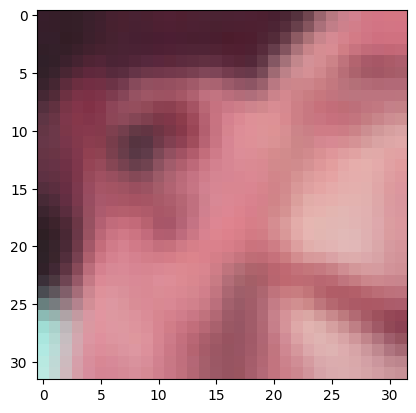

In [92]:
import matplotlib.pyplot as plt
from torchvision import transforms
# Import the required functions and classes from your code

num_patch = 2
scale_min = 1
scale_max = 1
ratio_min = 1
ratio_max = 1
BS = 2
# Load the CIFAR-20 dataset for testing
testset = load_cifar20_coarse(train=False, num_patch=num_patch)
# Create a DataLoader with a batch size of 4 for testing
dataloader = DataLoader(testset, batch_size=BS, shuffle=True)
# Define a function to display images and labels

# Iterate through the DataLoader and display images and labels
for batch in dataloader:
    images, labels, fine_labels = batch
    show_images(images, labels, fine_labels)

    break





